In [123]:
import jdc

import os

from io import BytesIO
from PIL import Image as PILImage
from datetime import datetime,timedelta
import dateutil
import piexif
import xmltodict
from fractions import Fraction
import re
from bs4 import BeautifulSoup
import numpy as np
import struct
#import tifffile as tf

import matplotlib.pyplot as plt

import logging
logger = logging.getLogger(__name__)


from tags import *
from jfif_utils import *
import jfif

path = "G:/Geteilte Ablagen/thermal DRONES GmbH/Wildretter-Daten/verschiedene Kameras"
 


In [124]:
class ImageBaseClass(object):
    maker = ""
    def __init__(self, filepath=None,ifd=None,rawdata= b'',img=None,onlyheader=False):
        self.header = {"camera":{},"uav":{},"image":{"main":{},"thumbnail":{}},"file":{},"position":{},
         "calibration":{"geometric":{},"radiometric":{},"boresight":{}},"exif":{},}
        self.ifd = ifd
        self.rawdata = rawdata
        self.img = img
        self.onlyheader = onlyheader
        
        if os.path.exists(filepath): 
            filename = os.path.basename(str(filepath))
            self.header["file"]["path"]=filepath.replace("\\","/")
            self.header["file"]["name"]=filename
            self.header["file"]["extension"]=os.path.splitext(filename)[1]
            self.header["file"]["modified"]=datetime.fromtimestamp(os.path.getmtime(filepath)).strftime("%Y-%m-%d %H:%M:%S")
            self.header["file"]["created"]=datetime.fromtimestamp(os.path.getctime(filepath)).strftime("%Y-%m-%d %H:%M:%S")
    
    def load_xmp(self,rawdata):
            xmp_start = rawdata.lower().find(b"<rdf:rdf")
            xmp_end = rawdata.lower().find(b"</rdf:rdf")
            xmp_str = rawdata[xmp_start:xmp_end+10]
            if len(xmp_str)>0:
                xmp_bs = BeautifulSoup(xmp_str,"lxml")
                xmp_od = xmltodict.parse(bytes(str(xmp_bs.find("rdf:rdf")),"utf-8"))
                self.xmp = dict(xmp_od.get("rdf:rdf").get("rdf:description"))
            else:
                self.xmp = {}
    
    def load_exif(self):
        self.exif = {}
        for ifdkey, ifd in self.ifd.items():
            if ifdkey == "thumbnail":
                try:
                    self.thumbnail = np.array(PILImage.open(BytesIO(ifd))) 
                    self.images.append(self.thumbnail)
                    nested_set(self.header, ["image","thumbnail","index"],len(self.images)-1)
                except:
                    self.thumbnail = ifd
                    logger.warning("reading thumbnail failed")
                continue
            else:
                self.exif[ifdkey]={}

            if type(ifd)==dict:
                for k,v in ifd.items():
                    typ = piexif.TAGS[ifdkey][k]["type"]
                    self.exif[ifdkey][piexif.TAGS[ifdkey][k]["name"]]=v
        

In [125]:
class ImageFlir(ImageBaseClass,jfif.JFIF):
    bitdepth = 8
    maker = "Flir"
    endian = ">"
    
    @classmethod
    def is_registrar_for(cls, maker, filepath):
        return maker in [b'FLIR',b'FLIR Systems AB',b'FLIR\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00']
    
    def __init__(self, filepath=None,ifd=None,rawdata= b'',img=None,onlyheader=False):
        super().__init__(filepath,ifd,rawdata,img)
        self.images = []
        self.rawimage = np.array([])
        self.segments = self.main_segments(rawdata)
        self.load_fff()
        self.load_exif()
        self.load_xmp(rawdata)
        self.load_header()
        self.params = {"exif":self.exif,"xmp":self.xmp,"fff":self.fff}
        
        
    
    def latlon(self,key,refkey, defaultref=b"N",ref=[b"S",b"South"],defaultval=((0,1),(0,1),(0,1))):
        ll = self.ifd["GPS"].get(key,defaultval)
        llref = self.ifd["GPS"].get(refkey,defaultref) 
        if llref in ref :
            return -rational2float(ll[0])
        else:
            return rational2float(ll[0])
        
    def alt(self):
        alt = self.ifd["GPS"].get(piexif.GPSIFD.GPSAltitude,(0,1))
        altref = self.ifd["GPS"].get(piexif.GPSIFD.GPSAltitudeRef,0) 
        if altref == 1:
            return -rational2float(alt)
        else:
            return rational2float(alt)
    
    def combine_flir_segments(self):
        flirdata = []
        start = 10
        for s in self.segments:
            if not s[1]=="APP1": continue
            if s[2]-s[0]<6: continue
            if not self.rawdata[s[0]+4:s[0]+8] == b"FLIR": continue    
            length = 256 * self.rawdata[s[0]+2] + self.rawdata[s[0]+3]
            if start<length:
                flirdata.append(self.rawdata[s[0]+2+start:s[0]+2+length])
        return b"".join(flirdata)
        
    def get_raw(self,bytearr):
        geom = {}
        for i in GEOMETRIC_INFO:
            val = struct.Struct("<"+i[2]).unpack_from(bytearr,i[0])
            if "s" in i[2]:
                val = val[0].strip(b"\x00")
            name = i[1]
            geom[name]=val[0]
        img = np.frombuffer(bytearr[32:], dtype="<u"+str(geom['pixelSize']),count=geom['imageWidth']*geom['imageHeight']) 
        img = np.reshape(img,(geom['imageHeight'],geom['imageWidth']))
        bitdepth = geom["pixelSize"]
        return img, bitdepth
    
    def load_fff(self):
        fffchunk = self.combine_flir_segments()
        ffh = {}
        if len(fffchunk)<64:  return
        for i in FLIRFILEHEAD:
            val = struct.unpack_from(">"+i[2],fffchunk[0:64],i[0])
            if "s" in i[2]:
                val = val[0].strip(b"\x00")
            name = i[1]
            ffh[name]=val[0]
        
        indexes = ffh["Number of indexes"]
        FFI = []
        for idx in range(0,indexes):
            ffi = {}
            for i in FLIRFILEINDEX:
                val = struct.Struct(">"+i[2]).unpack_from(fffchunk[64+idx*32:96+idx*32],i[0])
                if "s" in i[2]:
                    val = val[0].strip(b"\x00")
                name = i[1]
                ffi[name]=val[0]
            if ffi["MainType"]== 1:
                rawstart= ffi['DataPtr']
                rawend = rawstart + ffi['DataSize']
            if ffi["MainType"]== 32:
                basicstart= ffi['DataPtr']
                basicend = basicstart + ffi['DataSize']
            FFI.append(ffi)
        self.fff = self.decode_struct(fffchunk[basicstart:basicend],FFF,"<")
        if not self.onlyheader:
            self.rawimage,self.bitdepth = self.get_raw(fffchunk[rawstart:rawend])
            self.images.append(self.rawimage)
            nested_set(self.header, ["image","thumbnail","index"],len(self.images)-1)
        else:
            self.bitdepth = struct.Struct(">"+i[2]).unpack_from(fffchunk[rawstart:rawstart+2],0)
        
    def load_header(self):
        nested_set(self.header,["image","main","width"],self.ifd["Exif"].get(piexif.ExifIFD.PixelXDimension,-1))
        nested_set(self.header,["image","main","height"],self.ifd["Exif"].get(piexif.ExifIFD.PixelYDimension,-1))
        nested_set(self.header,["image","main","bitdepth"],self.ifd["0th"].get(piexif.ImageIFD.BitsPerSample,-1))
        nested_set(self.header,["image","main","channels"],self.ifd["0th"].get(piexif.ImageIFD.SamplesPerPixel,-1))
        nested_set(self.header,["image","main","orientation"],self.ifd["0th"].get(piexif.ImageIFD.Orientation,-1))
        nested_set(self.header,["image","main","resolution"],resolution(self.ifd["0th"]))
        
        #self.header["exif"]["ExifVersion"] = int(self.ifd["Exif"].get(piexif.ExifIFD.ExifVersion,0).decode("UTF-8"))/100
        
        #self.header["gps"]["DateTime"] = isotimestr(*self.fff.get('DateTimeOriginal',(0,0,0)))
        
        
        self.header["position"]["Latitude"] = self.latlon(piexif.GPSIFD.GPSLatitude,piexif.GPSIFD.GPSLatitudeRef)
        self.header["position"]["Longitude"] = self.latlon(piexif.GPSIFD.GPSLongitude,piexif.GPSIFD.GPSLongitudeRef,b'E',[b"W",b"West"])
        self.header["position"]["Altitude"] = self.alt() #self.latlon(piexif.GPSIFD.GPSAltitude,piexif.GPSIFD.GPSAltitudeRef,0,[1],(0,1))
        
        
        self.header["camera"]["Pitch"] =  evaldiv(self.xmp.get("camera:pitch","0/1"))
        self.header["camera"]["Roll"] =  evaldiv(self.xmp.get("camera:roll","0/1"))
        self.header["camera"]["Yaw"] =  evaldiv(self.xmp.get("camera:yaw","0/1"))
        
        self.header["camera"]["Model"] =  self.fff.get("CameraModel",b"").strip(b"\x00").decode("utf-8")
        self.header["camera"]["PartNumber"] =  self.fff.get("CameraPartNumber",b"").strip(b"\x00").decode("utf-8") 
        self.header["camera"]["SerialNumber"] = self.fff.get('CameraSerialNumber',b"").strip(b"\x00").decode("utf-8") 
        self.header["camera"]["FieldOfView"] = self.fff.get('FieldOfView',[-1])
        self.header["camera"]["FrameRate"] = self.fff.get('FrameRate',[-1])
        
        #DateTimeOriginal': (1589706416, 165, -120),
        
        nested_set(self.header,["image","raw_thermal","Width"], self.fff.get("Raw Thermal Image Width",[-1]))
        nested_set(self.header,["image","raw_thermal","Height"], self.fff.get("Raw Thermal Image Height",[-1]))
        
        self.header["calibration"]["radiometric"]["Emissivity"] = self.fff.get("Emissivity",[-1])
        self.header["calibration"]["radiometric"]["ObjectDistance"] = self.fff.get("ObjectDistance",[-1])
        
        self.header["calibration"]["radiometric"]["R"] = float(self.fff.get("PlanckR1",(0)))
        self.header["calibration"]["radiometric"]["F"] = float(self.fff.get("PlanckF",(1)))
        self.header["calibration"]["radiometric"]["B"] = float(self.fff.get("PlanckB",(0)))
        self.header["calibration"]["radiometric"]["R2"] = float(self.fff.get("PlanckR2",(0)))
        self.header["calibration"]["radiometric"]["Coretemp"] = self.fff.get("Coretemp",(1))
          
        #self.header["calibration"]["radiometric"]["Timestamp"] = 
        self.header["calibration"]["radiometric"]["IRWindowTemperature"] = float(self.fff.get("IRWindowTemperature",(0)))
        self.header["calibration"]["radiometric"]["IRWindowTransmission"] = float(self.fff.get("IRWindowTransmission",(1)))
            
  
        

In [126]:
class ImageDJI(ImageBaseClass,jfif.JFIF):
    bitdepth = 8
    maker = "DJI"
    endian = "<"
    
    @classmethod
    def is_registrar_for(cls, maker, filepath):
        return maker in [b'DJI',b'Hasselblad',b'DJI\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00']
   
    def __init__(self, filepath=None,ifd=None,rawdata= b'',img=None,onlyheader=False):
        super().__init__(filepath,ifd,rawdata,img)
        self.images = []
        self.rawimage = np.array([])
        self.segments = self.main_segments(rawdata)
        self.load_exif()
        self.load_xmp(rawdata)
        self.load_header()
        self.params = {"exif":self.exif,"xmp":self.xmp}
        if not onlyheader:
            self.mainimage = np.array(PILImage.open(BytesIO(rawdata)))
            self.images.append(self.mainimage)
            nested_set(self.header, ["image","main","index"],len(self.images)-1)
            self.load_rawimage()
    
    def load_header(self):
        nested_set(self.header,["image","main","width"],self.ifd["Exif"].get(piexif.ExifIFD.PixelXDimension,-1))
        nested_set(self.header,["image","main","height"],self.ifd["Exif"].get(piexif.ExifIFD.PixelYDimension,-1))
        nested_set(self.header,["image","main","bitdepth"],self.ifd["0th"].get(piexif.ImageIFD.BitsPerSample,-1))
        nested_set(self.header,["image","main","channels"],self.ifd["0th"].get(piexif.ImageIFD.SamplesPerPixel,-1))
        nested_set(self.header,["image","main","orientation"],self.ifd["0th"].get(piexif.ImageIFD.Orientation,-1))
        nested_set(self.header,["image","main","resolution"],resolution(self.ifd["0th"]))
        
        #self.header["gps"]["datetime"] = self.ifd["0th"].get(piexif.ImageIFD.ResolutionUnit,1)
        
        nested_set(self.header,["image","thumbnail","width"],self.ifd["1st"].get(piexif.ImageIFD.ImageWidth,-1))
        nested_set(self.header,["image","thumbnail","height"], self.ifd["1st"].get(piexif.ImageIFD.ImageLength,-1))
        nested_set(self.header,["image","thumbnail","resolution"], resolution(self.ifd["1st"]))
        nested_set(self.header,["image","thumbnail","compression"], jfif.ExifCompression[self.ifd["1st"].get(piexif.ImageIFD.Compression,0)])
        
        nested_set(self.header,["main","pitch"], evaldiv(self.xmp.get("@drone-dji:gimbalpitchdegree","0/1")))
        nested_set(self.header,["main","roll"], evaldiv(self.xmp.get("@drone-dji:gimbalrolldegree","0/1")))
        nested_set(self.header,["main","yaw"], evaldiv(self.xmp.get("@drone-dji:gimbalyawdegree","0/1")))

    def load_rawimage(self):
        app3, app4 = [], []
        for s in self.segments:
            if s[1] == "APP3": app3.append(self.rawdata[s[0]+4:s[2]])
            elif s[1] == "APP4": app4.append(self.rawdata[s[0]+4:s[2]])
        raw_app3 = b"".join(app3)        
        raw_app4 = b"".join(app4)        
        
        nested_set(self.header,["image","raw_thermal","width"],self.ifd["Exif"].get(piexif.ExifIFD.PixelXDimension,-1))
        nested_set(self.header,["image","raw_thermal","height"],self.ifd["Exif"].get(piexif.ExifIFD.PixelYDimension,-1))
        nested_set(self.header,["image","raw_thermal","bitdepth"],self.ifd["0th"].get(piexif.ImageIFD.BitsPerSample,-1))
        nested_set(self.header,["image","raw_thermal","channels"],self.ifd["0th"].get(piexif.ImageIFD.SamplesPerPixel,-1))
        nested_set(self.header,["image","raw_thermal","orientation"],self.ifd["0th"].get(piexif.ImageIFD.Orientation,-1))
        nested_set(self.header,["image","raw_thermal","resolution"],resolution(self.ifd["0th"]))
        
        cnt = self.header["image"]["main"]["width"]*self.header["image"]["main"]["height"]
        
        if len(raw_app3) == cnt*2:
            raw = raw_app3
        elif len(raw_app4) == cnt*2:
            raw = raw_app4
            
        if len(raw) == cnt*2:    
            self.rawimage = np.frombuffer(raw, dtype="<u2",count=cnt) 
            self.rawimage = np.reshape(self.rawimage,(self.header["image"]["main"]["height"],self.header["image"]["main"]["width"]))
            self.images.append(self.rawimage)
            nested_set(self.header, ["image","raw_thermal","index"],len(self.images)-1)
        

In [127]:
class ImageParrot(ImageBaseClass,jfif.JFIF):
    bitdepth = 8
    maker = "Parrot"
    
    @classmethod
    def is_registrar_for(cls, maker, filepath):
        return maker in [b'Parrot',b'Parrot\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00']
    
    def __init__(self, filepath=None,ifd=None,rawdata= b'',img=None,onlyheader=False):
        super().__init__(filepath,ifd,rawdata,img)
        self.images = []
        self.segments = self.main_segments(rawdata)
        self.load_exif()
        self.load_xmp(rawdata)
        self.params = {"exif":self.exif,"xmp":self.xmp}
        self.load_header()
        if not onlyheader:
            self.mainimage = np.array(PILImage.open(BytesIO(rawdata)))
            self.images.append(self.mainimage)
            nested_set(self.header, ["image","main","index"],len(self.images)-1)
            self.load_rawimage()
            
    def load_header(self):
        self.header["image"]["width"]= self.ifd["0th"].get(piexif.ImageIFD.ImageWidth,-1)
        self.header["image"]["height"]= self.ifd["0th"].get(piexif.ImageIFD.ImageLength,-1)
        self.header["image"]["bitdepth"]= self.ifd["0th"].get(piexif.ImageIFD.BitsPerSample,-1)
        self.header["image"]["channels"]= self.ifd["0th"].get(piexif.ImageIFD.SamplesPerPixel,-1)
        self.header["image"]["orientation"]= self.ifd["0th"].get(piexif.ImageIFD.Orientation,-1)
        
    def load_rawimage(self):
        raw_thermal_chunk = []
        raw_vis_chunk = []
        start = 10
        for s in self.segments:
            if not s[1]=="APP1": continue
            if s[2]-s[0]<6: continue
            length = 256 * self.rawdata[s[0]+2] + self.rawdata[s[0]+3]
            if self.rawdata[s[0]+4:s[0]+8] == b"PART":
                raw_thermal_chunk.append(self.rawdata[s[0]+2+start:s[0]+2+length])        
            elif self.rawdata[s[0]+4:s[0]+8] == b"PARV": 
                raw_vis_chunk.append(self.rawdata[s[0]+2+start:s[0]+2+length])        
        self.raw_thermal = b"".join(raw_thermal_chunk)
        self.raw_vis = b"".join(raw_vis_chunk)
        
        endian = ENDIAN[self.raw_thermal[0:4]]
        length = struct.Struct(endian["format"]+"I").unpack_from(self.raw_thermal[4:8])[0]
        raw_thermal_body = self.raw_thermal[8:length]
        self.raw_thermal_header = self.decode_struct(self.raw_thermal[length:],AnafiRawImageMeta)
        self.raw_thermal_image = np.frombuffer(raw_thermal_body, dtype="<u2",count=self.raw_thermal_header["Raw Image Width"]*self.raw_thermal_header["Raw Image Height"]) 
        self.raw_thermal_image = np.reshape(self.raw_thermal_image,(self.raw_thermal_header["Raw Image Height"],self.raw_thermal_header["Raw Image Width"]))
        self.images.append(self.raw_thermal_image)
        nested_set(self.header, ["image","raw_thermal","index"],len(self.images)-1)
        self.raw_vis_image = np.array(PILImage.open(BytesIO(self.raw_vis)))
        self.images.append(self.raw_vis_image)
        nested_set(self.header, ["image","raw_vis","index"],len(self.images)-1)
        

In [128]:
class ImageYuneec(ImageBaseClass,jfif.JFIF):
    bitdepth = 8
    maker = "Yuneec"
    
    @classmethod
    def is_registrar_for(cls, maker, filepath):
        return maker in [b'YUNEE',b'Yuneec\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00']
    
    def __init__(self, filepath=None,ifd=None,rawdata= b'',img=None,onlyheader=False):
        super().__init__(filepath,ifd,rawdata,img)
        self.images = []
        self.segments = self.main_segments(rawdata)
        self.load_exif()
        self.load_xmp(rawdata)
        self.params = {"exif":self.exif,"xmp":self.xmp}
        self.load_header()
    #    if not onlyheader:
    #        self.rawimage,self.bitdepth = get_raw(fffchunk)
    
    def load_header(self):
        self.header["image"]["width"]= self.ifd["0th"].get(piexif.ImageIFD.ImageWidth,-1)
        self.header["image"]["height"]= self.ifd["0th"].get(piexif.ImageIFD.ImageLength,-1)
        self.header["image"]["bitdepth"]= self.ifd["0th"].get(piexif.ImageIFD.BitsPerSample,-1)
        self.header["image"]["channels"]= self.ifd["0th"].get(piexif.ImageIFD.SamplesPerPixel,-1)
        self.header["image"]["orientation"]= self.ifd["0th"].get(piexif.ImageIFD.Orientation,-1)

class ImageAra(ImageBaseClass):
    maker = "Intel"
    @classmethod
    def is_registrar_for(cls, maker, filepath):
        base, ext = os.path.splitext(filepath)
        return ext.lower() in ['.ara',".raw"]

class ImageTiff(ImageBaseClass):
    maker = "unknown"
    @classmethod
    def is_registrar_for(cls, maker, filepath):
        base, ext = os.path.splitext(filepath)
        return ext.lower() in ['.tiff',".tif"]

class ImageJpg(ImageBaseClass,jfif.JFIF):
    maker = "unknown"
    
    @classmethod
    def is_registrar_for(cls, maker, filepath):
        base, ext = os.path.splitext(filepath)
        return ext.lower() in ['.jpg',".jpeg"]     
    
    def __init__(self, filepath=None,ifd=None,rawdata= b'',img=None,onlyheader=False):
        super().__init__(filepath,ifd,rawdata,img)
        self.images = []
        self.segments = self.main_segments(rawdata)
        self.load_exif()
        self.load_xmp(rawdata)
        self.params = {"exif":self.exif,"xmp":self.xmp,"fff":self.fff}
        

In [129]:
def Image(filepath=None,onlyheader=False):
    img = None 
    ifd = {}
    rawdata = b''
    if os.path.exists(filepath):
        with open(filepath,"rb") as f:
            rawdata = f.read()
            try:
                ifd = piexif.load(rawdata)
            except:
                ifd = {}    
        if not onlyheader:
            try:
                img = PILImage.open(BytesIO(rawdata))
            except:
                logger.info("PIL does not identify an image")
    else:
        logger.warning("file does not exist")
    ifd0 = ifd.get("0th", {})
    maker = ifd0.get(piexif.ImageIFD.Make,"Unknown")
    for cls in ImageBaseClass.__subclasses__():
        if cls.is_registrar_for(maker, filepath):
            instance =  cls(filepath,ifd,rawdata,img,onlyheader)
            
            return instance
    logger.error("unknown fileformat")
    return None   

In [130]:
#flir = Image("C:/Users/marti/OneDrive/Dokumente/GitHub/poitagger2/poitagger/data/calib_flight/700101_000318_8.jpg")
flir = Image("G:/Geteilte Ablagen/thermal DRONES GmbH/Wildretter-Daten/verschiedene Kameras/FLIR/FLIR_Vue_640_20200517_110530/20200517_110530_R.jpg")
#flir = Image("G:/Geteilte Ablagen/thermal DRONES GmbH/Wildretter-Daten/verschiedene Kameras/FLIR/Flir_VuePro/vuepro_example.jpg") 
#flir = Image("G:/Geteilte Ablagen/thermal DRONES GmbH/Wildretter-Daten/verschiedene Kameras/FLIR/FLIR_Vue_640_20200517_110530/20200517_110655_R.jpg")
print (flir.maker, type(flir).__name__)
#flir.xmp
#flir.exif
#flir.fff
#flir.header
#plt.imshow(flir.rawimage)
#flir.segments
#data = flir.combine_flir_segments()
#data[0:20]
#plt.imshow(flir.rawimage)
#flir.exif
#flir.header
#flir.xmp
#flir.params = {}
#flir.params["exif"] = flir.exif
#flir.params["xmp"] = dict(flir.xmp)
#flir.params["fff"] = flir.fff
#flir.params
flir.ifd

reading thumbnail failed


Flir ImageFlir


{'0th': {271: b'FLIR\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00',
  272: b'Vue Pro 640 19mm\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00',
  282: (72, 1),
  283: (72, 1),
  296: 2,
  305: b'22.20.16.1\x00\x00\x00\x00\x00',
  531: 1,
  34665: 302,
  34853: 1900},
 'Exif': {36864: b'0210',
  37121: b'\x01\x02\x03\x00',
  37396: (320, 256, 640, 512),
  40960: b'0100',
  40961: 1,
  40962: 640,
  40963: 512},
 'GPS': {0: (2, 2, 0, 0),
  1: b'N',
  2: ((48, 1), (8, 1), (253436272, 10000000)),
  3: b'E',
  4: ((11, 1), (1, 1), (1604461, 10000000)),
  5: 0,
  6: (588000, 1000),
  7: ((11, 1), (5, 1), (32, 1)),
  12: b'K',
  13: (-648, 1000),
  14: b'T',
  15: (2819, 100)},
 'Interop': {},
 '1st': {259: 6, 274: 1, 282: (72, 1), 283: (72, 1), 296: 2},
 'thumbnail': None}

In [131]:
anafi = Image("G:/Geteilte Ablagen/thermal DRONES GmbH/Wildretter-Daten/verschiedene Kameras/Parrot/AnafiUSA_320pix_50deg/P0180018.JPG")
print (anafi.maker, type(anafi).__name__)
#anafi.params.keys()

Parrot ImageParrot


DJI ImageDJI


{'exif': {'0th': {'ImageWidth': 640,
   'ImageLength': 512,
   'BitsPerSample': (8, 8, 8),
   'ImageDescription': b'default',
   'Make': b'DJI',
   'Model': b'MAVIC2-ENTERPRISE-ADVANCED',
   'Orientation': 1,
   'SamplesPerPixel': 3,
   'XResolution': (72, 1),
   'YResolution': (72, 1),
   'ResolutionUnit': 2,
   'Software': b'10.00.01.75',
   'DateTime': b'2021:08:21 12:50:50',
   'YCbCrPositioning': 1,
   'ExifTag': 332,
   'GPSTag': 650,
   'XPComment': (48,
    0,
    46,
    0,
    57,
    0,
    46,
    0,
    49,
    0,
    52,
    0,
    50,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
   

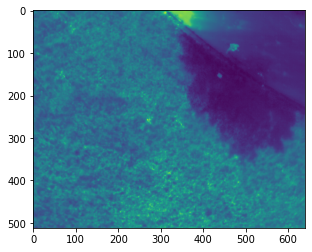

In [132]:
#dji = Image(os.path.join(path,"DJI/DJI-Farbkamera_neu/DJI_0001.JPG"))
dji = Image(os.path.join(path,"DJI/Testmaterial Mavic 2 Enterprise Advanced/Hausen_2021-08/DJI_0010.JPG"))
#dji = Image("C:/Users/marti/Downloads/dji_thermal_sdk_v1.2_20211209/dataset/M2EA/DJI_0005_R.JPG")
#dji = Image("C:/Users/marti/Downloads/dji_thermal_sdk_v1.2_20211209/dataset/XTS/DJI_0001_R.jpg")
print (dji.maker, type(dji).__name__)


#dji.decode_struct(DJI_Thermal_Params)
plt.imshow(dji.rawimage)
#dji.exif
#dji.xmp
#dji.header

#plt.imshow(dji.images[2])
dji.params

{'camera': {},
 'uav': {},
 'image': {'main': {'width': 640,
   'height': 512,
   'bitdepth': -1,
   'channels': -1,
   'orientation': -1,
   'resolution': {'x': 1.0, 'y': 1.0, 'unit': 'None'},
   'index': 1},
  'thumbnail': {'index': 0,
   'width': -1,
   'height': -1,
   'resolution': {'x': 1.0, 'y': 1.0, 'unit': 'None'},
   'compression': 'JPEG (old-style)'},
  'raw_thermal': {'width': 640,
   'height': 512,
   'bitdepth': -1,
   'channels': -1,
   'orientation': -1,
   'resolution': {'x': 1.0, 'y': 1.0, 'unit': 'None'},
   'index': 2}},
 'file': {'path': 'G:/Geteilte Ablagen/thermal DRONES GmbH/Wildretter-Daten/verschiedene Kameras/DJI/XTS/DJI_0001_R.jpg',
  'name': 'DJI_0001_R.jpg',
  'extension': '.jpg',
  'modified': '2021-12-09 12:25:12',
  'created': '2022-01-11 22:08:34'},
 'position': {},
 'calibration': {'geometric': {}, 'radiometric': {}, 'boresight': {}},
 'exif': {},
 'main': {'pitch': 0.0, 'roll': 0.0, 'yaw': 0.0}}

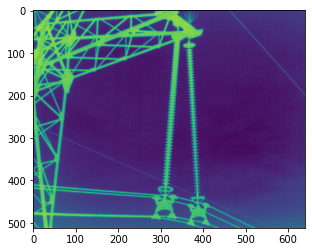

In [133]:
dji4 = Image("G:/Geteilte Ablagen/thermal DRONES GmbH/Wildretter-Daten/verschiedene Kameras/DJI/XTS/DJI_0001_R.jpg")
dji4.exif
plt.imshow(dji4.rawimage)
dji4.header

{'camera': {},
 'uav': {},
 'image': {'main': {'width': 640,
   'height': 512,
   'bitdepth': -1,
   'channels': -1,
   'orientation': 1,
   'resolution': {'x': 72.0, 'y': 72.0, 'unit': 'inches'},
   'index': 1},
  'thumbnail': {'index': 0,
   'width': -1,
   'height': -1,
   'resolution': {'x': 72.0, 'y': 72.0, 'unit': 'inches'},
   'compression': 'JPEG'},
  'raw_thermal': {'width': 640,
   'height': 512,
   'bitdepth': -1,
   'channels': -1,
   'orientation': 1,
   'resolution': {'x': 72.0, 'y': 72.0, 'unit': 'inches'},
   'index': 2}},
 'file': {'path': 'G:/Geteilte Ablagen/thermal DRONES GmbH/Wildretter-Daten/verschiedene Kameras/DJI/H20T/DJI_0001_R.jpg',
  'name': 'DJI_0001_R.jpg',
  'extension': '.jpg',
  'modified': '2021-12-09 12:25:12',
  'created': '2022-01-11 22:08:35'},
 'position': {},
 'calibration': {'geometric': {}, 'radiometric': {}, 'boresight': {}},
 'exif': {},
 'main': {'pitch': 0.0, 'roll': 0.0, 'yaw': 0.0}}

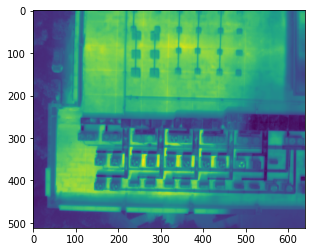

In [119]:
dji5 = Image("G:/Geteilte Ablagen/thermal DRONES GmbH/Wildretter-Daten/verschiedene Kameras/DJI/H20T/DJI_0001_R.jpg")

plt.imshow(dji5.rawimage)
dji5.exif
dji5.header

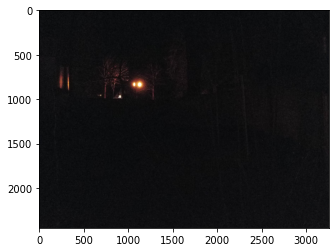

In [120]:
plt.imshow(anafi.raw_vis_image)

reading thumbnail failed


{'camera': {'Pitch': -90.0,
  'Roll': 0.0,
  'Yaw': -129.9361663928669,
  'Model': '',
  'PartNumber': '',
  'SerialNumber': '',
  'FieldOfView': 0.0,
  'FrameRate': 0},
 'uav': {},
 'image': {'main': {'width': 640,
   'height': 512,
   'bitdepth': 8,
   'channels': -1,
   'orientation': -1,
   'resolution': {'x': 72.0, 'y': 72.0, 'unit': 'inches'}},
  'thumbnail': {'index': 0},
  'raw_thermal': {'Width': 0, 'Height': 0}},
 'file': {'path': 'C:/WILDRETTER DATEN/210525_1130_obersöchering_dreieck_kühe/210525_112356_8.jpg',
  'name': '210525_112356_8.jpg',
  'extension': '.jpg',
  'modified': '2021-05-25 09:23:56',
  'created': '2021-05-25 11:34:01'},
 'position': {'Latitude': 47.0, 'Longitude': 11.0, 'Altitude': 719.04},
 'calibration': {'geometric': {},
  'radiometric': {'Emissivity': 0.0,
   'ObjectDistance': 0.0,
   'R': 0.0,
   'F': 0.0,
   'B': 0.0,
   'R2': 0.0,
   'Coretemp': 0.0,
   'IRWindowTemperature': 0.0,
   'IRWindowTransmission': 0.0},
  'boresight': {}},
 'exif': {}}

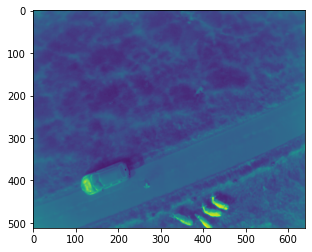

In [121]:
td = Image("C:/WILDRETTER DATEN/210525_1130_obersöchering_dreieck_kühe/210525_112356_8.jpg")
plt.imshow(td.rawimage)
td.header
#td.maker

In [122]:
yun = Image(os.path.join(path,"yuneec/200123_1448_Yuneec_H520_E90_Flug_Feuerhaus/YUN_0002.JPG"))
#yun = Image(os.path.join(path,"yuneec/e10T_thomas_Kaelber/YUN_0009.jpeg"))
print (yun.maker, type(yun).__name__)
yun.header
yun.xmp
#yun.segments
yun.exif

Yuneec ImageYuneec


{'0th': {'ImageDescription': b'DCIM\\108E90HD\\YUN_0002.',
  'Make': b'Yuneec\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00',
  'Model': b'E90\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00',
  'Orientation': 1,
  'XResolution': (72, 1),
  'YResolution': (72, 1),
  'ResolutionUnit': 2,
  'Software': b'1.0.28_E\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00',
  'DateTime': b'2020:01:23 13:31:51',
  'YCbCrPositioning': 1,
  'ExifTag': 158,
  'GPSTag': 710},
 'Exif': {'ExposureTime': (520, 1000000),
  'FNumber': (2800, 1000),
  'ExposureProgram': 2,
  'ISOSpeedRatings': 146,
  'ExifVersion': b'0230',
  'DateTimeOriginal': b'2020:01:23 13:31:51',
  'DateTimeDigitized': b'2020:01:23 13:31:51',
  'ComponentsConfiguration': b'\x00\x03\x02\x01',
  'CompressedBitsPerPixel': (12045421, 2495232),
  'ShutterSpeedValue': (-10906, -1000),
  'ApertureValue': (2800, 1000),
  'ExposureBia

# Tests

In [ ]:
djidual = Image("G:/Geteilte Ablagen/thermal DRONES GmbH/Wildretter-Daten/verschiedene Kameras/DJI/Testmaterial Mavic 2 Enterprise Advanced/100MEDIA_210820_1613/DJI_0069.jpg")
#djidual.xmp
print (djidual.maker, type(djidual).__name__)

In [96]:
dji = Image(os.path.join(path,"DJI/DJI-Farbkamera_neu/DJI_0001.JPG"))
dji.rawimage.shape


UnboundLocalError: local variable 'raw' referenced before assignment

In [ ]:
plt.imshow(dji.rawimage)

In [ ]:
irdata = []
start = 2
arr = dji.rawdata.split(b"\xff\xe3")
for i in arr[1:]:
    length = 256 * i[0] + i[1]
    if start<length:
        irdata.append(i[start:length])
rawimage = np.frombuffer(b"".join(irdata), dtype="<u2",count=dji.header["image"]["width"]*dji.header["image"]["height"]) 
rawimage = np.reshape(rawimage,(dji.header["image"]["height"],dji.header["image"]["width"]))
        


In [ ]:

irdata = []
start = 2
arr = dji.rawdata.split(b"\xff\xe3")
len(arr)
for i in arr[1:]:
    length = 256 * i[0] + i[1]
    if start<length:
        irdata.append(i[start:length])
bytearr = b"".join(irdata)
len(bytearr)    
img = np.frombuffer(bytearr, dtype="<u2",count=640*512) 
img = np.reshape(img,(512,640))
    

## Tests andere

In [ ]:
intel = Image(os.path.join(path,"Intel/Asctec_FLIR_neueFirmware/BRH08151352_0018.ARA"))
print (intel.maker, type(intel).__name__)
intel.header

In [ ]:
class ImageTD(ImageBaseClass,jfif.JFIF):
    bitdepth = 8
    maker = "thermal DRONES"
    endian = ">"
    rawimage = np.array([])
    
    @classmethod
    def is_registrar_for(cls, maker, filepath):
        return maker in [b'FLIR',b'FLIR Systems AB',b'FLIR\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00']
    
    def __init__(self, filepath=None,ifd=None,xmp={},rawdata= b'',img=None,onlyheader=False):
        super().__init__(filepath,ifd,xmp,rawdata,img)
        self.segments = self.main_segments(rawdata)
        self.extract_fff()
    
    def latlon(self,key,refkey, defaultref=b"N",ref=[b"S",b"South"],defaultval=((0,1),(0,1),(0,1))):
        ll = self.ifd["GPS"].get(key,defaultval)
        llref = self.ifd["GPS"].get(refkey,defaultref) 
        if llref in ref :
            return -rational2float(ll[0])
        else:
            return rational2float(ll[0])
        
    def alt(self):
        alt = self.ifd["GPS"].get(piexif.GPSIFD.GPSAltitude,(0,1))
        altref = self.ifd["GPS"].get(piexif.GPSIFD.GPSAltitudeRef,0) 
        if altref == 1:
            return -rational2float(alt)
        else:
            return rational2float(alt)
    
    def combine_flir_segments(self):
        flirdata = []
        start = 10
        for s in self.segments:
            if not s[1]=="APP1": continue
            if s[2]-s[0]<6: continue
            if not self.rawdata[s[0]+4:s[0]+8] == b"FLIR": continue    
            length = 256 * self.rawdata[s[0]+2] + self.rawdata[s[0]+3]
            if start<length:
                flirdata.append(self.rawdata[s[0]+2+start:s[0]+2+length])
        return b"".join(flirdata)
        
    def get_raw(self,bytearr):
        geom = {}
        for i in GEOMETRIC_INFO:
            val = struct.Struct("<"+i[2]).unpack_from(bytearr,i[0])
            if "s" in i[2]:
                val = val[0].strip(b"\x00")
            name = i[1]
            geom[name]=val[0]
        img = np.frombuffer(bytearr[32:], dtype="<u"+str(geom['pixelSize']),count=geom['imageWidth']*geom['imageHeight']) 
        img = np.reshape(img,(geom['imageHeight'],geom['imageWidth']))
        bitdepth = geom["pixelSize"]
        return img, bitdepth
    
    
    def flir_header(self,fffmeta):    
        fff = {}
        for i in FFF:
            val = struct.Struct(self.endian+i[2]).unpack_from(fffmeta,i[0])
            if "s" in i[2]:
                val = val[0].strip(b"\x00")
            name = i[1]
            fff[name]=val
        return fff    

    def extract_fff(self):
        fffchunk = self.combine_flir_segments()
        ffh = {}
        if len(fffchunk)<64:  return
        for i in FLIRFILEHEAD:
            val = struct.unpack_from(">"+i[2],fffchunk[0:64],i[0])
            if "s" in i[2]:
                val = val[0].strip(b"\x00")
            name = i[1]
            ffh[name]=val[0]
        
        indexes = ffh["Number of indexes"]
        FFI = []
        for idx in range(0,indexes):
            ffi = {}
            for i in FLIRFILEINDEX:
                val = struct.Struct(">"+i[2]).unpack_from(fffchunk[64+idx*32:96+idx*32],i[0])
                if "s" in i[2]:
                    val = val[0].strip(b"\x00")
                name = i[1]
                ffi[name]=val[0]
            if ffi["MainType"]== 1:
                rawstart= ffi['DataPtr']
                rawend = rawstart + ffi['DataSize']
            if ffi["MainType"]== 32:
                basicstart= ffi['DataPtr']
                basicend = basicstart + ffi['DataSize']
            FFI.append(ffi)
        self.fff = self.flir_header(fffchunk[basicstart:basicend])
        if not self.onlyheader:
            self.rawimage,self.bitdepth = self.get_raw(fffchunk[rawstart:rawend])
        else:
            self.bitdepth = struct.Struct(">"+i[2]).unpack_from(fffchunk[rawstart:rawstart+2],0)
        
    def load_header(self):
        self.exif = {}
        for ifdkey, ifd in self.ifd.items():
            if ifdkey == "thumbnail":
                self.thumbnail = ifd 
                continue
            else:
                self.exif[ifdkey]={}
            for k,v in ifd.items():
                typ = piexif.TAGS[ifdkey][k]["type"]
                self.exif[ifdkey][piexif.TAGS[ifdkey][k]["name"]]=v
        
        self.header["image"]["Width"]= self.ifd["Exif"].get(piexif.ExifIFD.PixelXDimension,-1)
        self.header["image"]["Height"]= self.ifd["Exif"].get(piexif.ExifIFD.PixelYDimension,-1)
        self.header["image"]["Bitdepth"]= self.ifd["0th"].get(piexif.ImageIFD.BitsPerSample,-1)
        self.header["image"]["Channels"]= self.ifd["0th"].get(piexif.ImageIFD.SamplesPerPixel,1)
        
        self.header["image"]["Orientation"]= self.ifd["0th"].get(piexif.ImageIFD.Orientation,1)
        
        self.header["image"]["Resolution"] = resolution(self.ifd["0th"])
        
        self.header["exif"]["ExifVersion"] = int(self.ifd["Exif"].get(piexif.ExifIFD.ExifVersion,0).decode("UTF-8"))/100
        
        self.header["gps"]["DateTime"] = isotimestr(*self.fff.get('DateTimeOriginal',(0,0,0)))
        
        
        self.header["gps"]["Latitude"] = self.latlon(piexif.GPSIFD.GPSLatitude,piexif.GPSIFD.GPSLatitudeRef)
        self.header["gps"]["Longitude"] = self.latlon(piexif.GPSIFD.GPSLongitude,piexif.GPSIFD.GPSLongitudeRef,b'E',[b"W",b"West"])
        self.header["gps"]["Altitude"] = self.alt() #self.latlon(piexif.GPSIFD.GPSAltitude,piexif.GPSIFD.GPSAltitudeRef,0,[1],(0,1))
        
        
        self.header["camera"]["Pitch"] =  evaldiv(self.xmp.get("camera:pitch","0/1"))
        self.header["camera"]["Roll"] =  evaldiv(self.xmp.get("camera:roll","0/1"))
        self.header["camera"]["Yaw"] =  evaldiv(self.xmp.get("camera:yaw","0/1"))
        
        self.header["camera"]["Model"] =  self.fff.get("CameraModel",b"").decode("utf-8")
        self.header["camera"]["PartNumber"] =  self.fff.get("CameraPartNumber",b"").decode("utf-8") 
        self.header["camera"]["SerialNumber"] = self.fff.get('CameraSerialNumber',"").decode("utf-8") 
        self.header["camera"]["FieldOfView"] = self.fff.get('FieldOfView',[-1])[0]
        self.header["camera"]["FrameRate"] = self.fff.get('FrameRate',[-1])[0]
        
        #DateTimeOriginal': (1589706416, 165, -120),
        
        self.header["rawimage"]["Width"]= self.fff.get("Raw Thermal Image Width",[-1])[0]
        self.header["rawimage"]["Height"]= self.fff.get("Raw Thermal Image Height",[-1])[0]
        
        self.header["calibration"]["radiometric"]["Emissivity"] = self.fff.get("Emissivity",[-1])[0]
        self.header["calibration"]["radiometric"]["ObjectDistance"] = self.fff.get("ObjectDistance",[-1])[0]
        
        
        self.header["calibration"]["radiometric"]["R"] = float(self.fff.get("PlanckR1",(0))[0])
        self.header["calibration"]["radiometric"]["F"] = float(self.fff.get("PlanckF",(1))[0])
        self.header["calibration"]["radiometric"]["B"] = float(self.fff.get("PlanckB",(0))[0])
        self.header["calibration"]["radiometric"]["R2"] = float(self.fff.get("PlanckR2",(0))[0])
        self.header["calibration"]["radiometric"]["Coretemp"] = self.fff.get("Coretemp",(1))[0]
          
        #self.header["calibration"]["radiometric"]["Timestamp"] = 
        self.header["calibration"]["radiometric"]["IRWindowTemperature"] = float(self.fff.get("IRWindowTemperature",(0))[0])
        self.header["calibration"]["radiometric"]["IRWindowTransmission"] = float(self.fff.get("IRWindowTransmission",(1))[0])
            
  
        

In [ ]:
jpg = Image('test.jpg',onlyheader=True)
print (jpg.maker, type(jpg).__name__)
tif = Image('test.tiff')
print (tif.maker, type(tif).__name__)
ara = Image('test.ara')
print (ara.maker, type(ara).__name__)
#img = Image("bla.bla")
#print (img.maker, type(img).__name__)
jpg.header

## LIBS und Konstanten

# =========================================


In [ ]:
%%add_to ImageBaseClass
     
    def get_xmp(self,imgpath):
        xmp = ""
        d = []
        try:
            with open(imgpath,"rb") as f:
                d = f.read()
            xmp_start = d.lower().find(b"<rdf:rdf")
            xmp_end = d.lower().find(b"</rdf:rdf")
            xmp_str = d[xmp_start:xmp_end+10]
            xmp = BeautifulSoup(xmp_str,"lxml")
        except FileNotFoundError as e:
            logger.error(e)
        except:
            logger.error(e)
        return d, xmp

        
    def get_exif_xmp(filepath):
        with open(filepath,"rb") as f:
            rawdata = f.read()
            exif= piexif.load(rawdata)
        xmp_start = d.lower().find(b"<rdf:rdf")
        xmp_end = d.lower().find(b"</rdf:rdf")
        xmp_str = d[xmp_start:xmp_end+10]
        xmp_od = xmltodict.parse(xmp_str)
        xmp = xmp_od.get("rdf:RDF").get("rdf:Description")
        return exif, xmp, rawdata 

In [ ]:
%%add_to ImageDJI
#def __init__(self,filepath=None,onlyheader=False):
#    super().__init__(filepath)

def load(self,filepath,onlyheader=False):
    d, self.exif, self.xmp = self.get_meta(filepath)
    logger.info(self.xmp)

    self.segments = self.find_segments(d)
    self.width,self.height,self.channels = self.get_size(self.segments,d)


    self.rwidth = int(str(self.exif.get("Raw Thermal Image Width",0)))
    self.rheight = int(str(self.exif.get("Raw Thermal Image Height",0 )))

  #  self.extract_flir(d,onlyheader)

  #  if str(self.exif.get("Image Make","")) in ["DJI", "Hasselblad"]:
  #      logger.info("DJI")
  #      self.fill_header_dji()
  #      logger.info("after DJI FILL HEADER")
  #  elif str(self.exif.get("Image Make","")) == "FLIR":
  #      logger.info("FLIR")
  #      self.fill_header_flir()

  #  if not onlyheader:
  #      try:
  #          self.image = np.array(PILImage.open(imgpath))    
  #          if len(self.image.shape)==3:
  #              (self.height, self.width,self.channels) = self.image.shape
  #          else:
  #              (self.height,self.width) = self.image.shape
  #              self.channels = 1
  #      except:
  #          logger.warning("can not load image %s" % imgpath)


In [ ]:
%%add_to ImageBaseClass
def test2(self):
    print("This is Test2")

In [ ]:
%%add_to ImageDJI
def find_segments(self,d):
        cpattern = re.compile(b"..|".join(MARKER.keys()))
        segments = []
        parentend = 0
        try:
            for m in cpattern.finditer(d):
                if len(m.group())>=4: 
                    length = 256 * m.group()[2] + m.group()[3]
                    id = MARKER[m.group()[:-2]]
                else:
                    length = 0
                    id = MARKER[m.group()]
                if m.start()>parentend:
                    top = True
                    parentend = m.start() + length
                else:
                    top = False
                segments.append({"id":id, 
                    "pos":m.start(),
                    "len" : length,
                    "top": top})
        except Exception as e:
            logger.error(e, exc_info=False)
        return segments

def get_size(self,segments,data):
        Width, Height, Channels = [],[],[]
        try:
            sof = [i for i in segments if i["id"]=="SOF0" and i["top"]==True ] #[0]
            for s in sof:
                p = s["pos"]
                precision = data[p+4]
                Height.append(struct.unpack(">H", data[p+5:p+7])[0])
                Width.append(struct.unpack(">H", data[p+7:p+9])[0])
                Channels.append(data[p+9])
            idx = Width.index(max(Width))
            return (Width[idx],Height[idx],Channels[idx])
        except:
            return (0,0,1)
            